In [ ]:
import os
import sys
import random

import numpy as np
import pandas as pd
import tensorflow as tf


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, schedules, Adam
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.models import Model, load_model
from tensorflow.python.keras import losses


from google.colab import drive

In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
image_height = 256
image_width = 256
dpath = '../content/drive/MyDrive/Breast Ultrasound Dataset/'
classes = ['benign', 'malignant', 'normal']

In [ ]:
data = {'image' : [],
        'mask' : []}

Preprocessing

In [ ]:
def load_data(path, data_obj, class_name):
    img_names_list = os.listdir(path+class_name)
    image_names = []
    mask_names = []
    names_truncated = []
    
    for i in range(len(img_names_list)):
        names_truncated.append(img_names_list[i].split(')')[0])
    
    names_truncated = list(set(names_truncated))
    
    for i in range(len(names_truncated)):
        image_names.append(names_truncated[i]+').png')
        mask_names.append(names_truncated[i]+')_mask.png')
    
    data_obj = preprocess_data(image_names, mask_names, image_width, image_height, path, class_name, data_obj)
        
        
    return data_obj

In [ ]:
def preprocess_data(image_names, mask_names, img_width, img_height, dpath, dclass, data_obj):
    for index in range (len(image_names)):
#         img = plt.imread(dpath+'/'+dclass+'/'+ image_names[index])
#         mask = plt.imread(dpath+'/'+dclass+'/'+ mask_names[index])

#         img = cv2.resize(img, (img_width, img_height)) 
#         mask = cv2.resize(mask, (img_width, img_height))
        
#         mask = np.expand_dims(mask, -1)

        image_path = dpath+'/'+dclass+'/'+ image_names[index]
        mask_path = dpath+'/'+dclass+'/'+ mask_names[index]
        
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = np.round(cv2.resize(x, (image_height, image_width)))
        x.dtype = np.uint8
        y = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        y = cv2.resize(y, (image_height, image_width))

        x= x/255.0
        y= y/255.0
        data_obj['image'].append(x)
        data_obj['mask'].append(y)

    return data_obj

In [ ]:
data = load_data(dpath, data, classes[0]) 
ln = len(data['image'])
print("Number of benign tumor images", ln)
data = load_data(dpath, data, classes[1]) 
print("Number of malignant tumor images", len(data['image'])-ln)
print("Total images for segmentation", len(data['image']))

Number of benign tumor images 437
Number of malignant tumor images 210
Total images for segmentation 647


Visualization

In [ ]:
def visualize_example(data, index = None):
    if index is None:
        index = random.randint(0, len(data['image']))
    X = data['image']
    y = data['mask']
    has_mask = y[index].max() > 0
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(X[index])
    if has_mask:
        ax[0].contour(y[index].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[index].squeeze())
    ax[1].set_title('Mask')

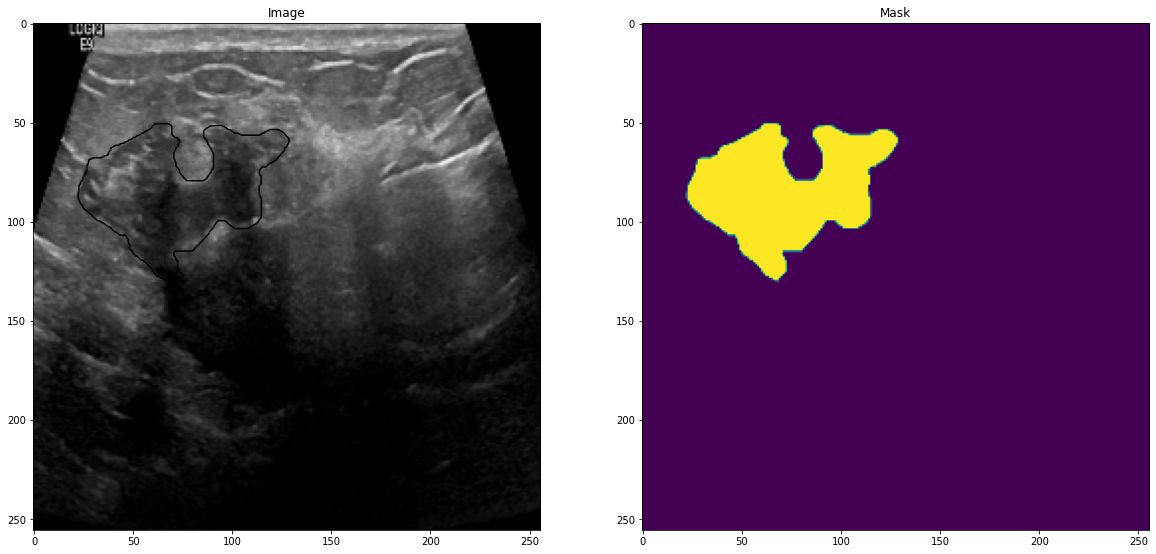

In [ ]:
visualize_example(data)

In [ ]:
data['image'] = np.array(data['image'])
data['image'].shape

(647, 256, 256, 3)

In [ ]:
data['mask'] = np.array(data['mask'])
data['mask'] = np.expand_dims(data['mask'], -1)
data['mask'].shape

(647, 256, 256, 1)

Train-Test Split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data['image'], data['mask'], test_size=0.2, random_state=42)
print(len(X_train), len(y_train), len(X_valid), len(y_valid))

517 517 130 130


In [ ]:
data_gen_args = dict(
    rotation_range=60,
    zoom_range=[0.6,1.0],
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode="nearest",
)

In [ ]:
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
seed = 1

In [ ]:
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

Fitting and Creating Train Generator

In [ ]:
image_generator = image_datagen.flow(
    X_train,
    batch_size = 16,
    seed=seed)
mask_generator = mask_datagen.flow(
    y_train,
    batch_size = 16,
    seed=seed)

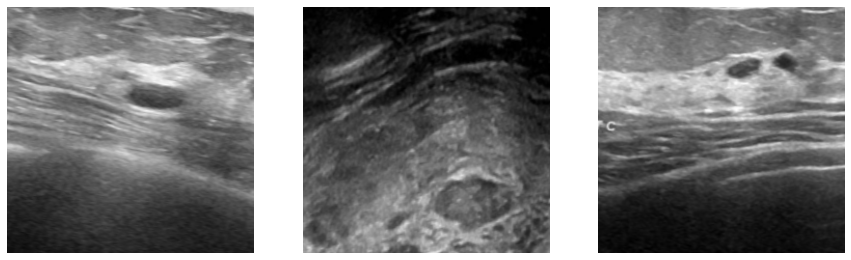

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for i in range(3):
    image = next(image_generator)[0]
    ax[i].imshow(image)
    ax[i].axis('off')

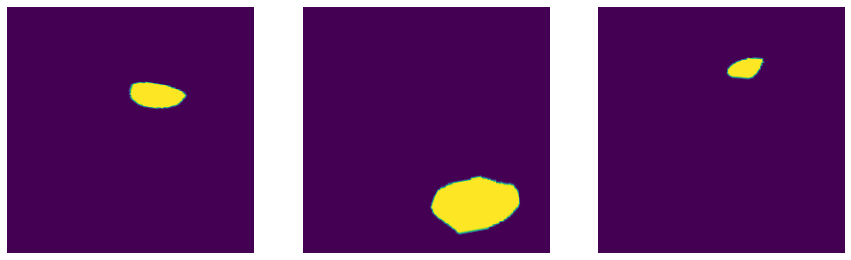

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for i in range(3):
    image = next(mask_generator)[0]
    ax[i].imshow(np.squeeze(image))
    ax[i].axis('off')

In [ ]:
train_generator = zip(image_generator, mask_generator)

In [ ]:
tf.keras.backend.clear_session()

 Defining Loss Functions

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [ ]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

Building U-net Model

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_layer= Input((image_height, image_width, 3), name='img')
unet_model = get_unet(input_layer, n_filters=16, dropout=0.05, batchnorm=True)
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

Setting up Hyperparameters

In [ ]:
unet_model.compile(optimizer=Adam(),
                  loss= bce_dice_loss,
                  metrics=[dice_loss, dice_coeff, 'accuracy'])

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
batch_size = 16
epochs = 50

Training the model

In [ ]:
model_history = unet_model.fit(train_generator,  
                    batch_size=batch_size, 
                    steps_per_epoch=int(np.ceil(len(X_train) / float(batch_size))),
                    epochs=epochs, 
                    callbacks=callbacks,
                    validation_data=(X_valid, y_valid),
                    verbose = 1)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.4418 - dice_loss: 0.7602 - dice_coeff: 0.2398 - accuracy: 0.6535
Epoch 1: val_loss improved from inf to 90.76880, saving model to model-checkpoint.h5
33/33 [==============================] - 28s 368ms/step - loss: 1.4418 - dice_loss: 0.7602 - dice_coeff: 0.2398 - accuracy: 0.6535 - val_loss: 90.7688 - val_dice_loss: 0.8458 - val_dice_coeff: 0.1542 - val_accuracy: 0.0902 - lr: 0.0010
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 1.1963 - dice_loss: 0.7230 - dice_coeff: 0.2770 - accuracy: 0.8428
Epoch 2: val_loss improved from 90.76880 to 4.79459, saving model to model-checkpoint.h5
33/33 [==============================] - 10s 314ms/step - loss: 1.1963 - dice_loss: 0.7230 - dice_coeff: 0.2770 - accuracy: 0.8428 - val_loss: 4.7946 - val_dice_loss: 0.8181 - val_dice_coeff: 0.1819 - val_accuracy: 0.2984 - lr: 0.0010
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 1.1187 - dice_los

Learning Curve Visualization

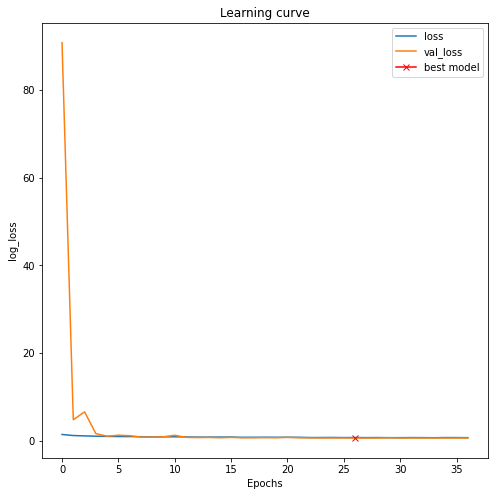

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_history.history["loss"], label="loss")
plt.plot(model_history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

Evaluating the model on test sets

In [ ]:
unet_model.load_weights('model-checkpoint.h5')
unet_model.evaluate(X_valid, y_valid, verbose=1)

5/5 [==============================] - 2s 60ms/step - loss: 0.6282 - dice_loss: 0.5114 - dice_coeff: 0.4886 - accuracy: 0.9429


[0.628183901309967,
 0.5114340782165527,
 0.48856592178344727,
 0.9429370760917664]

In [ ]:
preds_test = unet_model.predict(X_valid, verbose=1)
preds_test_t = (preds_test > 0.75).astype(np.uint8)

5/5 [==============================] - 1s 63ms/step


Testing

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Mask Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[3].set_title('Mask Predicted binary');

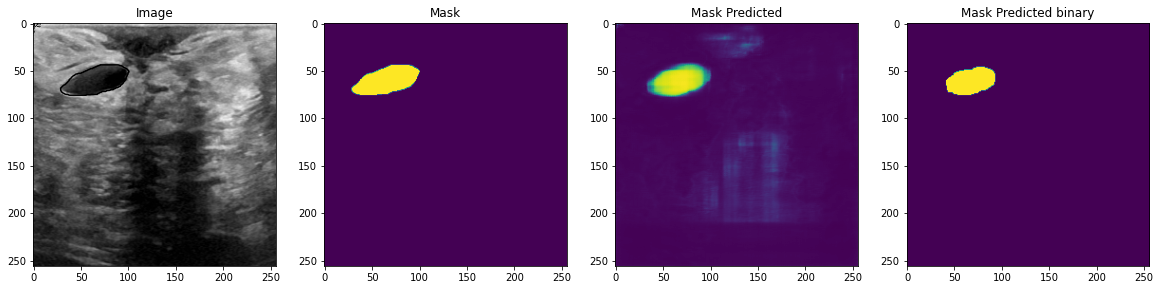

In [ ]:
plot_sample(X_valid, y_valid, preds_test, preds_test_t)